In [1]:
!copy "scripts\\deep_learning.py" .
!copy "scripts\\vectorizer.py" .

        1 arquivo(s) copiado(s).
        1 arquivo(s) copiado(s).


In [2]:
from IPython.display import clear_output

from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import numpy as np
from numpy import newaxis
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf

from collections import Counter
import emoji
import json
import re
import string
import os
import time

from deep_learning import (
    ConvolutedNeuralNetwork,
    LongShortTermMemoryNetwork,
    CombinedNeuralNetworks
)
from vectorizer import Word2VecModel

nltk.download('stopwords')
np.random.seed(10)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

tt = TweetTokenizer()
stpwrds = stopwords.words('portuguese') + list(string.punctuation)

C:\Users\mfbla\miniconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mfbla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
root_path = './drive/MyDrive/TCC Manuela/'
embedding_path = 'embeddings'
drive_path = 'tweets'
datasets_path = 'etiquetados'
results_path = 'results'
weights_path = 'weights\\weights.best2.hdf5'
vectorizers_path = 'vectorizers\\'

## Pré-processamento de tweets extraídos de contas relacionadas ao domínio de trânsito

In [8]:
accounts = ['OperacoesRio','Arteris_AFL','_ecoponte','LinhaAmarelaRJ','CETSP_',
           '_dersp']

In [9]:
total_tweets_before = 0
for account in accounts:
  with open(os.path.join(drive_path, f'{account}_tweets.json'), 'r', encoding='utf-8') as file:
    json_data = json.load(file)

  df = pd.json_normalize(json_data, record_path=['tweets'])[['text', 'id']]
  total_tweets_before += len(df.index)

  df_tokenized = df.copy()
  df_tokenized['text'] = df_tokenized['text'].apply(tt.tokenize)
  df_tokenized['text'] = df_tokenized['text'].apply(lambda row: [w.lower() for w in row])
  df_tokenized['text'] = df_tokenized['text'].apply(lambda row: [w.lower() for w in row if w.lower() not in stpwrds])
  df_tokenized['text'] = df_tokenized['text'].apply(lambda row: [emoji.replace_emoji(w, '') for w in row])
  df_tokenized['text'] = df_tokenized['text'].apply(lambda row: [re.sub('@|#|(http\S+)', '', w) for w in row])
  df_tokenized['text'] = df_tokenized['text'].apply(lambda row: [w for w in row if w != ''])
  df_empty_tweet = df_tokenized[[len(l) < 5 for l in df_tokenized['text']]]
  df_tokenized = df_tokenized.drop(df_empty_tweet.index, axis=0)
  df_sentences = df_tokenized.copy()
  df_sentences['text'] = df_tokenized['text'].apply(lambda row: ' '.join(row))

  df_sentences.to_csv(f'./df_{account}.csv', index=False)

## Criando um dataset único a partir dos datasets construídos para tweets de cada conta

In [10]:
df_ecoponte = pd.read_csv('df__ecoponte.csv')
df_dersp = pd.read_csv('df__dersp.csv')
df_operacoesrio = pd.read_csv('df_OperacoesRio.csv')
df_linhaamarelarj = pd.read_csv('df_LinhaAmarelaRJ.csv')
df_cetsp = pd.read_csv('df_CETSP_.csv')
df_arterisafl = pd.read_csv('df_Arteris_AFL.csv')

full_df = pd.concat([df_ecoponte, df_dersp, df_operacoesrio, df_linhaamarelarj, df_cetsp, df_arterisafl], ignore_index=True)

In [11]:
len(full_df.index)

39136

## Removendo randômicamente 7000 tweets
A remoção é necessária para que o número de tweets de domínio de trânsito seja proporcional ao número de tweets do público geral

In [12]:
qtd_removidos = 7000
indices_selecionados = np.random.choice(full_df.index, qtd_removidos, replace=False)

list_ids = full_df.iloc[indices_selecionados]['id'].to_list()
df_list_ids = full_df[full_df['id'].isin(list_ids)]

full_df = full_df.drop(df_list_ids.index, axis=0)
full_df.to_csv('./full_df.csv', index=False)

In [13]:
print('Total de tweets do domínio antes do pré-processamento:', total_tweets_before)

Total de tweets do domínio antes do pré-processamento: 40090


In [14]:
print('Total de tweets do domínio após o pré-processamento:', len(full_df.index))

Total de tweets do domínio após o pré-processamento: 32136


## Palavras mais mencionadas nos tweets de domínio de trânsito

In [15]:
Counter(" ".join(full_df['text']).split()).most_common(20)

[('sentido', 21079),
 ('minutos', 11882),
 ('normal', 11327),
 ('fluxo', 10060),
 ('rio', 9513),
 ('km', 8897),
 ('trecho', 7932),
 ('13', 7414),
 ('trânsito', 7291),
 ('tempo', 6928),
 ('niterói', 5941),
 ('lentidão', 5416),
 ('sp', 5249),
 ('tráfego', 5056),
 ('sentidos', 4943),
 ('bom', 4716),
 ('visibilidade', 4566),
 ('dois', 4267),
 ('lamsainforma', 3858),
 ('intenso', 3482)]

## Pré-processamento de tweets extraídos do público geral

In [16]:
with open(os.path.join(drive_path, 'random_tweets_5_most_common_words.json'), 'r', encoding='utf-8') as file:
  json_data_rt = json.load(file)

df_rt = pd.json_normalize(json_data_rt, record_path=['tweets'])[['text', 'id']]
df_rt_tokenized = df_rt.copy()
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(tt.tokenize)
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(lambda row: [w.lower() for w in row])
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(lambda row: [w.lower() for w in row if w.lower() not in stpwrds])
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(lambda row: [emoji.replace_emoji(w, '') for w in row])
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(lambda row: [re.sub('@|#|(http\S+)', '', w) for w in row])
df_rt_tokenized['text'] = df_rt_tokenized['text'].apply(lambda row: [w for w in row if w != ''])
df_rt_empty_tweet = df_rt_tokenized[[len(l) < 5 for l in df_rt_tokenized['text']]]
df_rt_tokenized = df_rt_tokenized.drop(df_rt_empty_tweet.index, axis=0)
df_rt_sentences = df_rt_tokenized.copy()
df_rt_sentences['text'] = df_rt_tokenized['text'].apply(lambda row: ' '.join(row))

df_rt_sentences.to_csv('./df_random_tweets_5_most_common_words.csv', index=False)

In [17]:
print('Total de tweets do público geral antes do pré-processamento:', len(df_rt.index))

Total de tweets do público geral antes do pré-processamento: 34992


In [18]:
print('Total de tweets do público geral após o pré-processamento:', len(df_rt_sentences.index))

Total de tweets do público geral após o pré-processamento: 32101


## Etiquetamento
---

Quantidade **total** de tweets: 64237

### Dataset com tweets do público geral:
Quantidade de tweets: 32101

- 297 tweets que **mencionam** eventos de trânsito
- 31804 tweets que **não mencionam** eventos de trânsito


### Dataset com tweets extraídos de perfis voltados ao domínio de trânsito:
Quantidade de tweets: 32136

- 29335 tweets que **mencionam** eventos de trânsito
- 2801 tweets que **não mencionam** eventos de trânsito

## Unificando datasets

In [19]:
labeled_random_tweets = pd.read_csv(os.path.join(datasets_path, 'novo_df_rt_classificacao.csv'))
labeled_dominio_transito = pd.read_csv(os.path.join(datasets_path, 'novo_dominio_transito_classificacao.csv'))
unified_dataset = pd.concat([labeled_random_tweets, labeled_dominio_transito], ignore_index=True)

unified_dataset.to_csv(os.path.join(datasets_path, 'unified_labeled_dataset.csv'), index=False)

In [20]:
unified_dataset['word_count'] = unified_dataset['text'].apply(lambda x: len(str(x).split(' ')))

<Axes: ylabel='Frequency'>

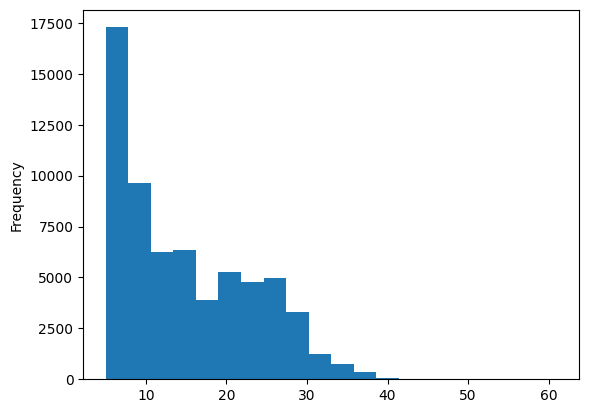

In [21]:
unified_dataset['word_count'].plot.hist(bins=20)

<Axes: ylabel='Frequency'>

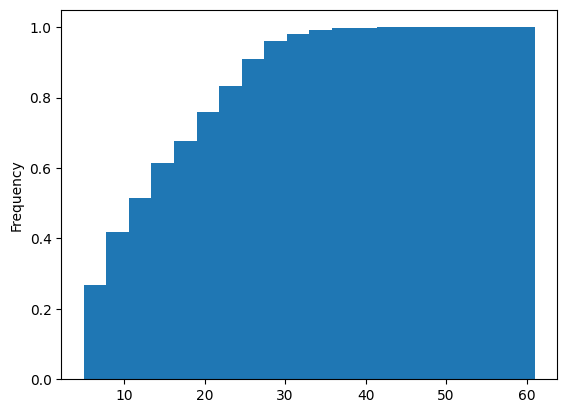

In [22]:
unified_dataset['word_count'].plot.hist(cumulative=True, bins=20, density=True)

## Separando dataset em conjuntos de treino e teste

In [23]:
cleaned_unified_dataset = unified_dataset[['classificacao_manuela', 'id', 'text']]

train, test = train_test_split(
    cleaned_unified_dataset,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

train_path = os.path.join(datasets_path, 'unified_dataset_training.csv')
test_path = os.path.join(datasets_path, 'unified_dataset_testing.csv')

train.to_csv(train_path, index=False)
test.to_csv(test_path, index=False)

In [24]:
hf_train_path = os.path.join(datasets_path, 'hf_unified_dataset_training.csv')
hf_test_path = os.path.join(datasets_path, 'hf_unified_dataset_testing.csv')

hf_train = train.rename(columns = {'classificacao_manuela':'label'})
hf_test = test.rename(columns = {'classificacao_manuela':'label'})

hf_train.to_csv(hf_train_path, index=False)
hf_test.to_csv(hf_test_path, index=False)

#### Criando conjunto de predição

In [25]:
qtd_tweets_pred = 100
df_pred_list_ids = df_list_ids.copy()
df_pred_list_ids.reset_index(drop=True, inplace=True)

indices_selecionados_pred = np.random.choice(df_pred_list_ids.index, qtd_tweets_pred, replace=False)

list_ids_pred = df_pred_list_ids.loc[indices_selecionados_pred]['id'].to_list()
pred_dataset = df_pred_list_ids[df_pred_list_ids['id'].isin(list_ids_pred)]

In [26]:
prediction_path = os.path.join(datasets_path, 'prediction_dataset.csv')
pred_dataset.to_csv(prediction_path, index=False)

## Experimentos com CNNs e LSTMs

### Configurando modelos

In [27]:
num_runs = 1

In [28]:
HEADER = '''\
vectorizer,\
dimensions,\
classifier,\
round,\
vector_time (s),\
train_time (s),\
accuracy,\
precision,\
recall,\
f1\

'''

In [29]:
HEADER_prediction = '''\
vectorizer,\
dimensions,\
classifier,\
prediction_time (s)\

'''

In [30]:
# with open(os.path.join(results_path, 'data_prediction_time.csv'), 'w') as file:
#    file.write(HEADER_prediction)
#    file.write('\n')

In [31]:
configs = [
    ('Pt-BR_Word2Vec', 'cnn', 50),
    ('Pt-BR_Word2Vec', 'cnn', 100),
    ('Pt-BR_Word2Vec', 'cnn', 300),
    ('Pt-BR_Word2Vec', 'cnn', 600),
    ('Pt-BR_Word2Vec', 'cnn', 1000),
    ('Pt-BR_Word2Vec', 'lstm', 50),
    ('Pt-BR_Word2Vec', 'lstm', 100),
    ('Pt-BR_Word2Vec', 'lstm', 300),
    ('Pt-BR_Word2Vec', 'lstm', 600),
    ('Pt-BR_Word2Vec', 'lstm', 1000),
    ('Pt-BR_Word2Vec', 'mixed', 50),
    ('Pt-BR_Word2Vec', 'mixed', 100),
    ('Pt-BR_Word2Vec', 'mixed', 300),
    ('Pt-BR_Word2Vec', 'mixed', 600),
    ('Pt-BR_Word2Vec', 'mixed', 1000),
    ('Pt-BR_GloVe', 'cnn', 50),
    ('Pt-BR_GloVe', 'cnn', 100),
    ('Pt-BR_GloVe', 'cnn', 300),
    ('Pt-BR_GloVe', 'cnn', 600),
    ('Pt-BR_GloVe', 'cnn', 1000),
    ('Pt-BR_GloVe', 'lstm', 50),
    ('Pt-BR_GloVe', 'lstm', 100),
    ('Pt-BR_GloVe', 'lstm', 300),
    ('Pt-BR_GloVe', 'lstm', 600),
    ('Pt-BR_GloVe', 'lstm', 1000),
    ('Pt-BR_GloVe', 'mixed', 50),
    ('Pt-BR_GloVe', 'mixed', 100),
    ('Pt-BR_GloVe', 'mixed', 300),
    ('Pt-BR_GloVe', 'mixed', 600),
    ('Pt-BR_GloVe', 'mixed', 1000),
    ('Pt-BR_FastText', 'cnn', 50),
    ('Pt-BR_FastText', 'cnn', 100),
    ('Pt-BR_FastText', 'cnn', 300),
    ('Pt-BR_FastText', 'cnn', 600),
    ('Pt-BR_FastText', 'cnn', 1000),
    ('Pt-BR_FastText', 'lstm', 50),
    ('Pt-BR_FastText', 'lstm', 100),
    ('Pt-BR_FastText', 'lstm', 300),
    ('Pt-BR_FastText', 'lstm', 600),
    ('Pt-BR_FastText', 'lstm', 1000),
    ('Pt-BR_FastText', 'mixed', 50),
    ('Pt-BR_FastText', 'mixed', 100),
    ('Pt-BR_FastText', 'mixed', 300),
    ('Pt-BR_FastText', 'mixed', 600),
    ('Pt-BR_FastText', 'mixed', 1000),
]

In [32]:
def create_vectorizer(train_path, test_path, vectorizer, embedding_path, dimensions, pred_dataset_path):
    vector = Word2VecModel(
        train_dataset=train_path,
        test_dataset=test_path,
        class_qtd='2class',
        base_model=vectorizer,
        embedding_path=embedding_path,
        set_dimensions=dimensions,
    )

    vectorized = vector.vectorize()
    # pred_vectorized = vector.prediction_only_vectorize(pred_dataset_path)
    # vector.save(
    #     vectorized['train_vectors'],
    #     vectorized['train_labels'],
    #     vectorized['test_vectors'],
    #     vectorized['test_labels'],
    #     vectorizers_path,
    #     network_type
    # )

    # return (vectorized, pred_vectorized)
    return vectorized

In [33]:
def run_network(config, train_path, test_path, embedding_path, weights_path, pred_dataset_path):
    vectorizer = config[0]
    network_type = config[1]
    dimensions = config[2]

    # vectorized, pred_vectorized = create_vectorizer(train_path, test_path, vectorizer, embedding_path, dimensions, pred_dataset_path)
    vectorized = create_vectorizer(train_path, test_path, vectorizer, embedding_path, dimensions, pred_dataset_path)

    if network_type == 'cnn':
        network = ConvolutedNeuralNetwork(
            train_vectors=vectorized['train_vectors'],
            train_labels=vectorized['train_labels'],
            test_vectors=vectorized['test_vectors'],
            test_labels=vectorized['test_labels'],
            weight_filepath=weights_path,
            vectorizing_time=vectorized['vectorizing_time']
        )
    elif network_type == 'lstm':
        network = LongShortTermMemoryNetwork(
            train_vectors=vectorized['train_vectors'],
            train_labels=vectorized['train_labels'],
            test_vectors=vectorized['test_vectors'],
            test_labels=vectorized['test_labels'],
            weight_filepath=weights_path,
            vectorizing_time=vectorized['vectorizing_time']
        )
    elif network_type == 'mixed':
        network = CombinedNeuralNetworks(
            train_vectors=vectorized['train_vectors'],
            train_labels=vectorized['train_labels'],
            test_vectors=vectorized['test_vectors'],
            test_labels=vectorized['test_labels'],
            weight_filepath=weights_path,
            vectorizing_time=vectorized['vectorizing_time']
        )
    network.train()
    network.test()
    return (
        network.vectorizing_time,
        network.train_time,
        network.metrics['accuracy'],
        network.metrics['precision'],
        network.metrics['recall'],
        network.metrics['f1'],
        network,
        # pred_vectorized['pred_vectors']
    )

In [34]:
def run(num_runs, filepath, config, train_path, test_path, embedding_path, weights_path, pred_dataset_path):
    for instance in range(num_runs):
        print(f'Rodada {instance + 1} de {num_runs}')
        if os.path.exists(weights_path):
            os.remove(weights_path)

        results = run_network(config, train_path, test_path, embedding_path, weights_path, pred_dataset_path)

        line_results = [
            str(config[0]),
            str(config[2]),
            str(config[1]),
            str(instance),
            str(results[0]),
            str(results[1]),
            str(results[2]),
            str(results[3]),
            str(results[4]),
            str(results[5]),
        ]
        with open(os.path.join(results_path, 'data_final_10_rounds.csv'), 'a') as file:
            file.write(','.join(line_results))
            file.write('\n')

        # line_results_pred = [
        #    str(config[0]),
        #    str(config[2]),
        #    str(config[1]),
        #]
        clear_output(wait=True)
        # return (results[6], results[7], line_results_pred)

### Executando modelos

In [35]:
###### prediction_time = 0
for config in configs:
    run(num_runs=num_runs,
        filepath=results_path,
        config=config,
        train_path=train_path,
        test_path=test_path,
        embedding_path=embedding_path,
        weights_path=weights_path,
        pred_dataset_path=prediction_path)
    # network, pred_vectors, line_results_predicted = run(num_runs=num_runs,
    #                                                     filepath=results_path,
    #                                                     config=config,
    #                                                     train_path=train_path,
    #                                                     test_path=test_path,
    #                                                     embedding_path=embedding_path,
    #                                                     weights_path=weights_path,
    #                                                     pred_dataset_path=prediction_path)
    # for iter in range(100):
    #     reshaped_input = pred_vectors[iter][newaxis, :, :]
    #     prediction_time = prediction_time + network.calculate_prediction_time(reshaped_input)

    # prediction_time = prediction_time / 100
    # line_results_predicted.append(str(prediction_time))
    # with open(os.path.join(results_path, 'data_prediction_time.csv'), 'a') as file:
    #     file.write(','.join(line_results_predicted))
    #     file.write('\n')
    clear_output(wait=True)

1/1 [==============================] - 0s 31ms/step
[1] 0.06237989999499405
1/1 [==============================] - 0s 16ms/step
[1] 0.05480379999789875
1/1 [==============================] - 0s 17ms/step
[1] 0.05964749999839114
1/1 [==============================] - 0s 12ms/step
[1] 0.06293059999734396
1/1 [==============================] - 0s 24ms/step
[1] 0.06100720000540605
1/1 [==============================] - 0s 41ms/step
[1] 0.09763830000156304
1/1 [==============================] - 0s 40ms/step
[1] 0.08384569999907399
1/1 [==============================] - 0s 24ms/step
[1] 0.07150199999887263
1/1 [==============================] - 0s 33ms/step
[1] 0.07256329999654554
1/1 [==============================] - 0s 36ms/step
[1] 0.07500930000242079
1/1 [==============================] - 0s 33ms/step
[1] 0.07947969999804627
1/1 [==============================] - 0s 21ms/step
[1] 0.06449440000142204
1/1 [==============================] - 0s 25ms/step
[1] 0.060459299995272886
1/1 [======

### Representações Gráficas dos Modelos

In [ ]:
config = ('Pt-BR_Word2Vec', 'mixed', 50)
vectorizer = config[0]
network_type = config[1]
dimensions = config[2]

# vectorized, pred_vectorized = create_vectorizer(train_path, test_path, vectorizer, embedding_path, dimensions, pred_dataset_path)
vectorized = create_vectorizer(train_path, test_path, vectorizer, embedding_path, dimensions, prediction_path)

In [ ]:
network = CombinedNeuralNetworks(
    train_vectors=vectorized['train_vectors'],
    train_labels=vectorized['train_labels'],
    test_vectors=vectorized['test_vectors'],
    test_labels=vectorized['test_labels'],
    weight_filepath=weights_path,
    vectorizing_time=vectorized['vectorizing_time']
)

In [ ]:
plot_model(network.model, to_file='graficos/model_plot_mixed.png', show_shapes=True, show_layer_names=False)